# Notebook 02 — SMC filtering for dynamic football team strengths (Premier League 2018–2023)

This notebook implements **online filtering** for a state-space skill rating model using a **bootstrap particle filter** with the **factorial (decoupling) approximation** described in Duffield et al. (2024).

**Goals**
1. Build a working particle filter that outputs time-varying team strength estimates.
2. Compute an approximate **incremental log-likelihood** along the season timeline.
3. Produce a first set of sanity checks (top teams, stability, no numerical issues).

We deliberately start with **fixed parameters** (not estimated yet). Parameter estimation via EM will be done in Notebook 03.


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

## 1. Model recap

We model each team $i \in \{1,\dots,N\}$ with a **latent strength** $x_t^i \in \mathbb{R}$ evolving in continuous time.

### 1.1 Prior
At the start of the observation window:
$
x_0^i \sim \mathcal{N}(0,\sigma_0^2).
$

### 1.2 Dynamics (random walk / Brownian motion)
Between two match times $t<t'$:
$
x_{t'}^i \mid x_t^i \sim \mathcal{N}\!\left(x_t^i,\ \tau^2 (t'-t)\right).
$

Here $\tau$ controls how fast strengths drift over time.

### 1.3 Observation model (home / draw / away)
For match $k$ at time $t_k$, with home team $h$ and away team $a$:
$
d_k = \frac{x_{t_k}^{h}-x_{t_k}^{a}}{s}.
$
Let $\sigma(z)=\frac{1}{1+e^{-z}}$ be the logistic sigmoid. With draw parameter $\varepsilon \ge 0$:
$
\mathbb{P}(y_k=\mathrm{D}\mid d_k)=\sigma(d_k+\varepsilon)-\sigma(d_k-\varepsilon),
$
$
\mathbb{P}(y_k=\mathrm{H}\mid d_k)=\sigma(d_k-\varepsilon),\qquad
\mathbb{P}(y_k=\mathrm{A}\mid d_k)=1-\sigma(d_k+\varepsilon).
$

We encode outcomes as:
- $0$ = Home win (H)
- $1$ = Draw (D)
- $2$ = Away win (A)


In [2]:
data_path = Path("../cleaned_football_data.csv")
df = pd.read_csv(data_path, parse_dates=["date"])

df.head()

,date,home_team,away_team,result,season,result_code
0,2018-08-10,Man United,Leicester,H,PL_2018-2019,0
1,2018-08-11,Bournemouth,Cardiff,H,PL_2018-2019,0
2,2018-08-11,Fulham,Crystal Palace,A,PL_2018-2019,2
3,2018-08-11,Huddersfield,Chelsea,A,PL_2018-2019,2
4,2018-08-11,Newcastle,Tottenham,A,PL_2018-2019,2


In [3]:
teams = pd.unique(df[["home_team", "away_team"]].values.ravel())
team_to_idx = {team: i for i, team in enumerate(teams)}
idx_to_team = {i: team for team, i in team_to_idx.items()}

N = len(teams)
print("Number of teams:", N)


Number of teams: 27


In [5]:
df["home_idx"] = df["home_team"].map(team_to_idx)
df["away_idx"] = df["away_team"].map(team_to_idx)

df[["home_team", "away_team", "home_idx", "away_idx"]].head()

,home_team,away_team,home_idx,away_idx
0,Man United,Leicester,0,1
1,Bournemouth,Cardiff,2,3
2,Fulham,Crystal Palace,4,5
3,Huddersfield,Chelsea,6,7
4,Newcastle,Tottenham,8,9


In [6]:
t0 = df["date"].min()
df["t"] = (df["date"] - t0).dt.days.astype(float)

df[["date", "t"]].head()


,date,t
0,2018-08-10,0.0
1,2018-08-11,1.0
2,2018-08-11,1.0
3,2018-08-11,1.0
4,2018-08-11,1.0


## 2. Inference objective (filtering) and rankings

Given match outcomes up to time $t_k$, $y_{1:k}$, the filtering target is:
$
p(x_{t_k}^{1:N}\mid y_{1:k}).
$

In practice we focus on marginal posteriors:
$
p(x_{t_k}^i \mid y_{1:k}) \quad \text{for each team } i.
$

A simple **ranking** at time $t_k$ is obtained by ordering teams by the posterior mean:
$
\mu_{i,k}=\mathbb{E}[x_{t_k}^i\mid y_{1:k}].
$

We will approximate these means using particles.


## 3. Why SMC and why the factorial approximation?

A particle filter approximates filtering distributions using a set of samples (particles). It is flexible and does not require a Gaussian approximation.

However, running SMC on the **full joint state** $x_{t_k}^{1:N}\in\mathbb{R}^N$ is not practical: the dimension grows with the number of teams.

We therefore use the **decoupling / factorial approximation**:
$
p(x_{t_k}^{1:N}\mid y_{1:k}) \approx \prod_{i=1}^N p(x_{t_k}^i\mid y_{1:k}).
$

This means we maintain one particle system per team and update **only the two teams involved in each match**.


## 4. Particle representation of marginal filters

For each team $i$, we represent the marginal filter as:
$
p(x_{t_k}^i\mid y_{1:k}) \approx \sum_{j=1}^J w_{k}^{i,j}\,\delta(x=x_{k}^{i,j}),
$
where:
- $x_{k}^{i,j}$ is particle $j$ for team $i$ after assimilating match $k$,
- $w_{k}^{i,j}$ are normalized weights.

In the bootstrap particle filter, after resampling, weights are typically reset to $1/J$.


## 5. Bootstrap particle filter: core steps

At each match $k$:

### 5.1 Propagate
For each team $i$ and each particle $j$:
$
x_{k}^{i,j} \leftarrow x_{k-1}^{i,j} + \eta,\qquad \eta \sim \mathcal{N}(0,\tau^2\Delta t_k),
$
where $\Delta t_k=t_k-t_{k-1}$.

### 5.2 Pairwise assimilation (teams involved in the match)
Let $h=h(k)$ and $a=a(k)$. We compute likelihood weights for pairs of particles:
$
\tilde{w}_{j,\ell} \propto G(y_k\mid x_{k}^{h,j}, x_{k}^{a,\ell}).
$

### 5.3 Resample
We resample $J$ pairs $(j,\ell)$ according to normalized weights. The updated particle sets are:
$
x_{k}^{h,j} \leftarrow x_{k}^{h,j^\star},\qquad x_{k}^{a,j} \leftarrow x_{k}^{a,\ell^\star}.
$

Other teams keep their propagated particles.


## 6. Predictive likelihood and log-likelihood estimate

The filtering recursion provides an estimate of the predictive probability of each observed match outcome:
$
p(y_k\mid y_{1:k-1},\theta).
$

Under our particle approximation, a simple estimator is:
$
\widehat{p}(y_k\mid y_{1:k-1},\theta)
= \frac{1}{J^2}\sum_{j=1}^J\sum_{\ell=1}^J G(y_k\mid x_{k}^{h,j}, x_{k}^{a,\ell}).
$

We then accumulate:
$
\widehat{\log p}(y_{1:K}\mid\theta) = \sum_{k=1}^K \log \widehat{p}(y_k\mid y_{1:k-1},\theta).
$

This log-likelihood estimate is what we will later use for:
- grid visualization (Figure 3-like)
- parameter estimation via EM (Notebook 03)


## 7. Practical sanity checks (what we expect to see)

With reasonable fixed parameters:
- the algorithm should run without numerical errors,
- the cumulative log-likelihood should be finite,
- top-ranked teams over 2018–2023 should look plausible (e.g., Man City, Liverpool, Arsenal, etc.),
- results can vary with the random seed and the number of particles $J$ (Monte Carlo variance).

At this stage, we do **not** aim for the best possible fit. We only validate that the filtering pipeline behaves sensibly.


In [7]:
# SMC parameters
J = 200        # number of particles
sigma0 = 1.0   # prior std
tau = 0.02     # dynamics std per day
s = 1.0        # observation scale
epsilon = 0.2  # draw parameter

In [8]:
rng = np.random.default_rng(42)

# particles[i] = array of shape (J,)
particles = {
    i: rng.normal(0.0, sigma0, size=J)
    for i in range(N)
}


In [9]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


In [10]:
def match_likelihood(xh, xa, result, s=1.0, eps=0.0):
    d = (xh - xa) / s

    if result == 1:  # draw
        return sigmoid(d + eps) - sigmoid(d - eps)
    elif result == 0:  # home win
        return sigmoid(d - eps)
    else:  # away win
        return 1.0 - sigmoid(d + eps)


In [11]:
def smc_update(particles, h, a, result, dt, *, tau, s, epsilon, rng):
    # Propagate all teams
    noise_std = tau * np.sqrt(dt)
    if noise_std > 0:
        for i in particles:
            particles[i] = particles[i] + rng.normal(0.0, noise_std, size=particles[i].shape[0])

    xh = particles[h]
    xa = particles[a]
    J = xh.shape[0]

    W = np.empty((J, J), dtype=float)
    for j in range(J):
        for l in range(J):
            W[j, l] = match_likelihood(xh[j], xa[l], result, s=s, eps=epsilon)

    Z = W.mean()
    Z = max(Z, 1e-300)

    W_sum = W.sum()
    if W_sum == 0 or not np.isfinite(W_sum):
        return np.log(Z)

    W /= W_sum

    flat_idx = rng.choice(J * J, size=J, p=W.ravel())
    j_idx = flat_idx // J
    l_idx = flat_idx % J

    particles[h] = xh[j_idx]
    particles[a] = xa[l_idx]

    return np.log(Z)



In [12]:
K = len(df)

loglik_incr = np.zeros(K, dtype=float)
loglik_cum = np.zeros(K, dtype=float)
means_over_time = np.zeros((K, N), dtype=float)

t_prev = 0.0
loglik = 0.0

for k, row in enumerate(df.itertuples(index=False)):
    h = row.home_idx
    a = row.away_idx
    result = row.result_code
    t = row.t

    dt = t - t_prev
    ll_k = smc_update(particles, h, a, result, dt, tau=tau, s=s, epsilon=epsilon, rng=rng)

    loglik += ll_k
    loglik_incr[k] = ll_k
    loglik_cum[k] = loglik

    # store posterior means after assimilating match k
    for i in range(N):
        means_over_time[k, i] = particles[i].mean()

    t_prev = t

print("Approx log-likelihood:", loglik)


Approx log-likelihood: -2062.8533881438857


In [13]:
final_means = means_over_time[-1]
top_idx = np.argsort(-final_means)[:10]

for idx in top_idx:
    print(idx_to_team[idx], round(final_means[idx], 3))

Man City 1.166
Liverpool 1.049
Arsenal 0.898
Man United 0.757
Newcastle 0.468
Aston Villa 0.338
Brighton 0.297
Tottenham 0.254
Brentford 0.235
Chelsea 0.091


## 8. Visual diagnostics

We plot:
1. The cumulative estimated log-likelihood over time.
2. The estimated posterior mean trajectories for a small set of teams.

These plots are sanity checks and will later support the EM and Figure 3-like analysis.


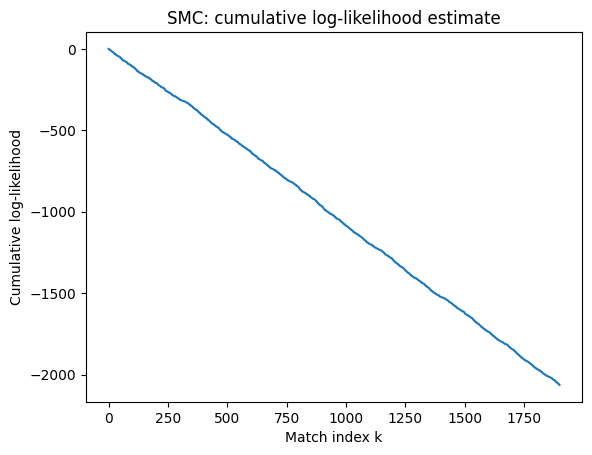

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loglik_cum)
plt.xlabel("Match index k")
plt.ylabel("Cumulative log-likelihood")
plt.title("SMC: cumulative log-likelihood estimate")
plt.show()


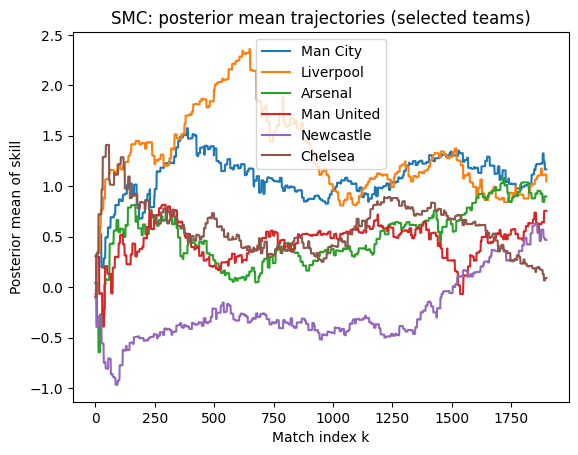

In [17]:
teams_to_plot = list(top_idx[:5])

for name in ["Man City", "Liverpool", "Arsenal", "Man United", "Chelsea"]:
    if name in team_to_idx:
        teams_to_plot.append(team_to_idx[name])

teams_to_plot = list(dict.fromkeys(teams_to_plot))  

plt.figure()
for idx in teams_to_plot:
    plt.plot(means_over_time[:, idx], label=idx_to_team[idx])
plt.xlabel("Match index k")
plt.ylabel("Posterior mean of skill")
plt.title("SMC: posterior mean trajectories (selected teams)")
plt.legend()
plt.show()


## 9. Saving outputs

We save the filtering outputs (means and log-likelihood estimates) to disk so that:
- the report figures can be reproduced,
- the EM notebook can reuse the same data structures without rerunning everything.


In [18]:
out = Path("../artifacts")
out.mkdir(exist_ok=True)

np.save(out / "means_over_time.npy", means_over_time)
np.save(out / "loglik_incr.npy", loglik_incr)
np.save(out / "loglik_cum.npy", loglik_cum)

teams_df = pd.DataFrame({"team": [idx_to_team[i] for i in range(N)], "team_idx": list(range(N))})
teams_df.to_csv(out / "teams_mapping.csv", index=False)

print("Saved to:", out.resolve())


Saved to: /Users/wissalhaouami/projects/skill_rating_ssm/code/artifacts
